<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Machine Learning Using Python (MEAFA Workshop)</h1>
<h2 align="center" style="margin-top:10px">Lesson 2: Regularised Linear Methods</h2>
<br>

<a href="Equity-Premium-Data">Equity Premium Data</a> <br>
<a href="#Exploratory-data-analysis">Exploratory Data Analysis</a> <br>
<a href="#Scaling-the-Predictors">Scaling the Predictors</a> <br>
<a href="#Regularised-Linear-Models">Regularised Linear Models</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

# Methods
from sklearn.linear_model import LinearRegression

##Equity Premium Data

We use data from [Goyal and Welch (2008)](https://academic.oup.com/rfs/article/21/4/1455/1565737), who conducted a detailed study of equity premium predictability. The updated quartely data that we use in this tutorial is available from Amit Goyal's [webpage](http://www.hec.unil.ch/agoyal/).

The question that we explore in this lesson is whether linear machine learning methods can help to predict the premium, or at least avoid overfiting noisy financial data. 

In [4]:
data=pd.read_excel('Datasets/PredictorData2015.xlsx', sheetname='Quarterly')
data.tail()

,yyyyq,Index,D12,E12,b/m,tbl,AAA,BAA,lty,cay,...,infl,ltr,corpr,svar,csp,ik,CRSP_SPvw,CRSP_SPvwx,D3,E3
575,20144,2058.900000,39.44,102.31,0.323756,0.0003,0.0379,0.0474,0.0240,-0.047225,...,-0.004404,0.090182,0.059225,0.005087,NaN,0.033620,0.050666,0.045080,10.47,22.83
576,20151,2067.889893,40.80,99.25,0.307454,0.0003,0.0364,0.0454,0.0223,-0.058516,...,-0.002559,0.028796,0.031934,0.004761,NaN,0.033464,0.010292,0.004963,10.55,21.81
577,20152,2063.110107,41.73,94.91,0.310187,0.0002,0.0419,0.0513,0.0261,-0.056800,...,0.006631,-0.069096,-0.072893,0.002513,NaN,0.033517,0.001510,-0.003636,10.69,22.80
578,20153,1920.030029,42.50,90.66,0.335612,0.0002,0.0407,0.0534,0.0240,-0.053225,...,0.000278,0.052134,0.030567,0.011060,NaN,0.033448,-0.063191,-0.068258,10.79,23.22
579,20154,2043.939941,43.38,86.53,0.313649,0.0023,0.0397,0.0546,0.0243,-0.056847,...,0.002324,-0.013940,0.004004,0.005576,NaN,0.032991,0.070375,0.064291,11.35,18.70


In [5]:
# Processing the predictors as Goyal and Welch
data['return']=100*(np.log(data['Index'])-np.log(data['Index'].shift(1)))
data['dp']=np.log(data['D12'])-np.log(data['Index'])
data['dy']=np.log(data['D12'])-np.log(data['Index'].shift(1))
data['ep']=np.log(data['E12'])-np.log(data['Index'])
data=data.rename(columns={'b/m': 'bm'})
data['tms']=data['ltr']-data['tbl']
data['dfy']=data['BAA']-data['AAA']
data['dfr']=data['corpr']-data['ltr']
data['ret']=data['return']-100*(data['tbl']/4)

In [6]:
#Data Wrangling
response='ret'
predictors=['dp', 'dy', 'ep', 'bm', 'ntis', 'tbl', 'tms', 'dfy', 'dfr', 'infl', 'ik']
data=data[['yyyyq']+predictors+[response]]
data[predictors]=data[predictors].shift(1) # lagging predictors by one periond
data=data.set_index('yyyyq')
data=data.dropna()
data.head().round(2)

,dp,dy,ep,bm,ntis,tbl,tms,dfy,dfr,infl,ik,ret
yyyyq,,,,,,,,,,,,
19472,-3.05,-3.06,-2.48,0.74,0.03,0.00,-0.00,0.01,0.00,0.02,0.04,0.17
19473,-3.00,-2.99,-2.36,0.74,0.03,0.00,-0.00,0.01,0.00,0.00,0.03,-0.86
19474,-2.95,-2.96,-2.28,0.74,0.02,0.01,0.00,0.01,-0.03,0.03,0.03,1.01
19481,-2.90,-2.89,-2.25,0.73,0.03,0.01,-0.05,0.01,0.02,0.02,0.03,-1.70
19482,-2.88,-2.89,-2.18,0.84,0.03,0.01,0.00,0.01,0.01,0.00,0.04,10.19


In [7]:
train = data.iloc[:220,:].copy()
test =  data.iloc[220:,:].copy()

y_train = train[response]
y_test = test[response]

X_train = train[predictors].copy()
X_test = test[predictors].copy()

## Exploratory data analysis

The two variables with strongest linear relationship with house values are the median income of the area, and the average number of rooms. Further exploration through the scatter plots below reveal nonlinear patterns for the median income, average rooms, and average occupancy. Population, housing average age, and average bedrooms seem to have only weak relationships with house values. 

In [8]:
train.describe().round(2)

,dp,dy,ep,bm,ntis,tbl,tms,dfy,dfr,infl,ik,ret
count,220.00,220.00,220.00,220.00,220.00,220.00,220.00,220.00,220.00,220.00,220.00,220.00
mean,-3.36,-3.34,-2.66,0.60,0.02,0.05,-0.03,0.01,0.00,0.01,0.04,0.73
std,0.40,0.40,0.40,0.25,0.02,0.03,0.06,0.00,0.02,0.01,0.00,7.65
min,-4.49,-4.50,-3.84,0.13,-0.03,0.00,-0.30,0.00,-0.09,-0.01,0.03,-32.28
25%,-3.52,-3.50,-2.91,0.47,0.01,0.03,-0.07,0.01,-0.01,0.00,0.03,-3.58
50%,-3.36,-3.34,-2.74,0.58,0.02,0.05,-0.03,0.01,0.00,0.01,0.04,1.97
75%,-3.09,-3.06,-2.35,0.76,0.03,0.06,-0.00,0.01,0.01,0.01,0.04,5.61
max,-2.60,-2.58,-1.77,1.20,0.05,0.15,0.17,0.03,0.04,0.04,0.04,18.17


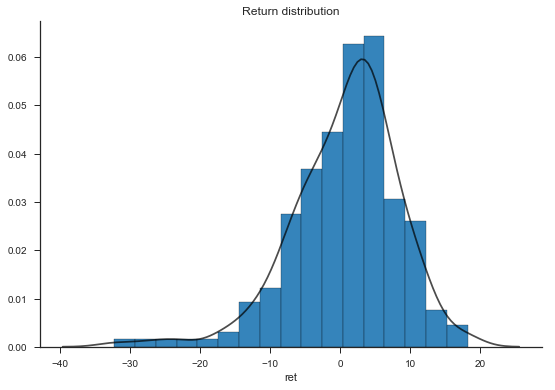

In [9]:
from statlearning import plot_histogram

plot_histogram(y_train)
plt.title('Return distribution')
plt.show()

This dataset is characterised by strong correlations between the predictors. 

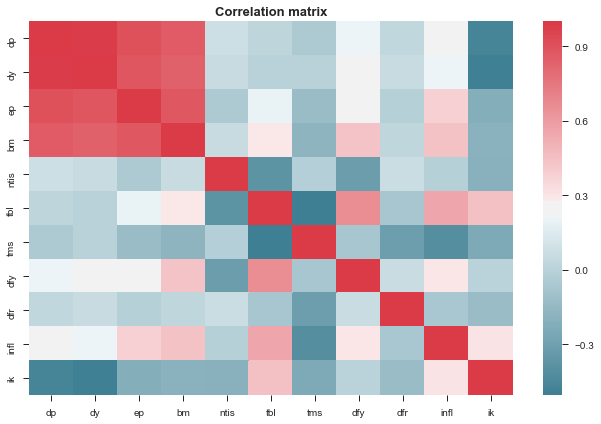

In [10]:
from statlearning import plot_correlation_matrix

plot_correlation_matrix(X_train)
plt.show()

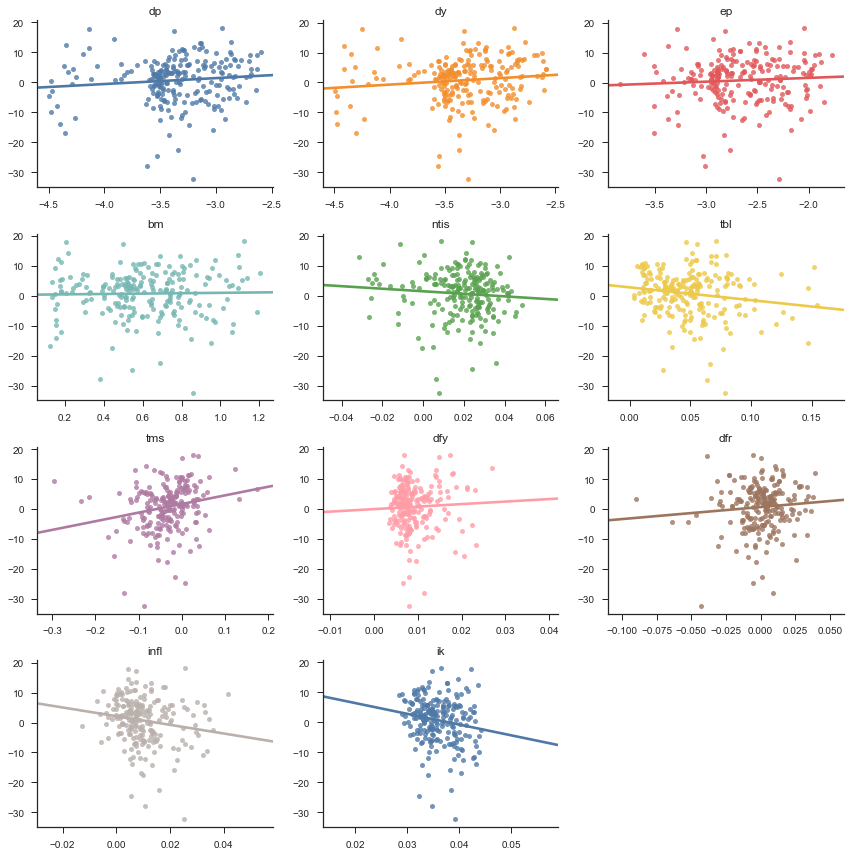

In [11]:
from statlearning import plot_regressions

with sns.color_palette(crayon):
    plot_regressions(X_train, y_train)
    plt.show()

## Scaling the Predictors

It is essential to scale the predictors before fitting regularised linear methods. Like several other machine learning algorithms, regularised linear methods do not perform well when predictors have very different scales, since the penalty term in the objective function treats all coefficients as comparable.  

The most common type of scaling is standardisation, where we transform each predictor by subtracting its sample average and diving the result by its standard deviation. The Scikit-Learn [<TT>StandardScaler</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) method makes it easy to process the data in this way.

We have two ways of implementing a workflow that includes scaling. The first is to use the standard scaler to preprocess the design matrix, and then work with the transformed as usual. 

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

We use a ridge regression to illustrate the process of fitting the model and computing predictions, without worrying about the details of the algorithm for now. 

In [13]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)
print(y_pred[0]) # this is to demonstrate that we will get the result below

1.89102960374


The other option is to use a Scikit-Learn [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline), which allows the user to combine transformations with a final estimator. 

In [14]:
from sklearn.pipeline import Pipeline

ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', Ridge()),
])

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print(y_pred[0]) # same result as above

1.89102960374


## Regularised Linear Models

We first fit a linear regression for reference. 

In [15]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

###Lasso

We use the [<TT>LassoCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) class to fit and tune the lasso model. The reason for this class, as opposed to running a grid search on the [<TT>Lasso</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) class, is that there is an efficient algorithm for computing the path of solutions as we vary the lasso penalty. The same is true of other models. 

Below, we present code according to the two ways of handling predictor scaling. 

In [16]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [17]:
lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
))

lasso.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

We can assess the regularisation strength by comparing the norm of the lasso coefficients with the OLS case. 

In [18]:
reg = lasso._final_estimator
round(np.linalg.norm(reg.coef_, ord=1)/np.linalg.norm(np.ravel(ols.coef_), ord=1),3)

0.001

In [19]:
pd.DataFrame(reg.coef_.round(3), index = predictors).T

,dp,dy,ep,bm,ntis,tbl,tms,dfy,dfr,infl,ik
0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.62,0.0,0.0,-0.029,-0.229


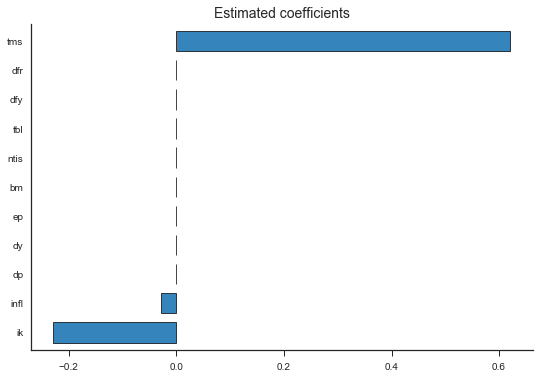

In [20]:
from statlearning import plot_coefficients

plot_coefficients(reg, predictors)
plt.show()

###Ridge Regression

In [21]:
from sklearn.linear_model import RidgeCV

alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=[3.0517578125e-05, 3.5055491790680982e-05, 4.0268185753567341e-05, 4.6255998733837822e-05, 5.3134189654304478e-05, 6.103515625e-05, 7.0110983581361965e-05, 8.0536371507134683e-05, 9.2511997467675645e-05, 0.00010626837930860896, 0.0001220703125, 0.00014022196716272393, 0.00016107274301426937, ...05, 16384.0, 18820.273848271459, 21618.817610103131, 24833.500225706386, 28526.20085808741, 32768.0],
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [22]:
ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
))

ridge.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', RidgeCV(alphas=[3.0517578125e-05, 3.5055491790680982e-05, 4.0268185753567341e-05, 4.6255998733837822e-05, 5.3134189654304478e-05, 6.103515625e-05, 7.0110983581361965e-05, 8.0536371507134683e-05, 9.251199746767...cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False))])

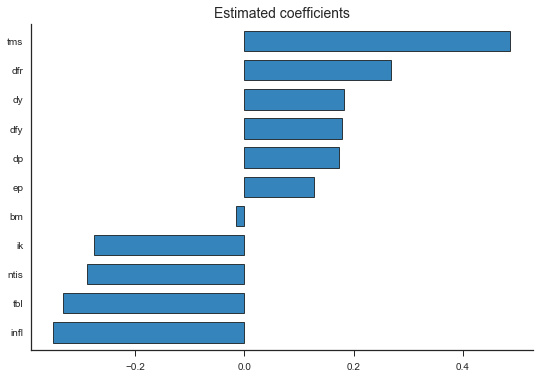

In [23]:
plot_coefficients(ridge._final_estimator, predictors)
plt.show()

###Elastic Net

In [24]:
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)
enet.fit(X_train_scaled, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [25]:
enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)),
))

enet.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0))])

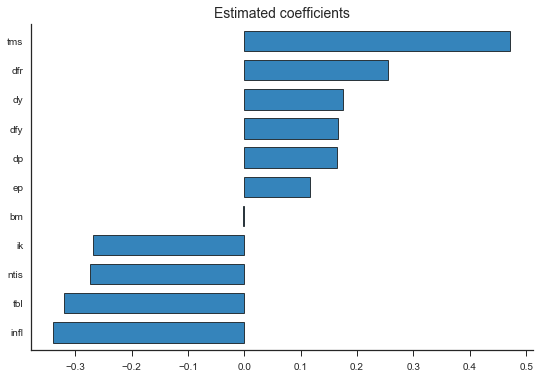

In [26]:
plot_coefficients(enet._final_estimator, predictors)
plt.show()

## Model evaluation


In [27]:
columns=['Test RMSE', 'Test R2', 'Test MAE']
rows=['OLS', 'Lasso', 'Ridge', 'Elastic Net']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, lasso, ridge, enet]

for i, method in enumerate(methods):
    
    y_pred=method.predict(X_test)   
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2,Test MAE
OLS,9.601,-0.300,6.381
Lasso,8.444,-0.005,6.217
Ridge,8.396,0.006,6.159
Elastic Net,8.391,0.007,6.162
